In [1]:
import torch
import os
import numpy as np
import torch.nn.functional as F
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_samples
from sklearn.datasets import make_blobs
from scipy.spatial import cKDTree  # 快速最近邻查询
import matplotlib.pyplot as plt
import json
import os
import sys
import models
from tasks import get_task_sampler
from samplers import get_data_sampler,rand_select_sampler
from munch import Munch
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import yaml
from curriculum import Curriculum
from graph import generate_points_nd, generate_points, generate_out_dis, generate_points_nd2, generate_moons, generate_circle_points
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.preprocessing import StandardScaler

In [2]:
def plot_decision_boundary2(model, X, y, ys_, task, resolution=30):
    X += torch.rand_like(X) * 0.1
    
    X_np = X[0].cpu().numpy()
    y_np = y[0].cpu().numpy()

    device = next(model.parameters()).device

    # 生成网格点
    x_min, x_max = X_np[:, 0].min() - 1, X_np[:, 0].max() + 1
    y_min, y_max = X_np[:, 1].min() - 1, X_np[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, resolution),
                         np.linspace(y_min, y_max, resolution))
    grid = np.c_[xx.ravel(), yy.ravel()]  # (resolution^2, 2)
    
    grid += torch.rand_like(torch.tensor(grid, dtype=torch.float32)) * 0.1
    # 预测每个 grid 点的概率
    probs = []
    class_map = []
    flag = True
    for i in range(len(grid)):
        g = grid[i]
        # 去掉最后一个点
        X_ctx = X[0][:-1]  # shape: (199, 2)
        ys_ctx = ys_[0][:-1]  # shape: (199, 2)

        g_tensor = torch.tensor(g, dtype=torch.float32).unsqueeze(0).to(device)

        x_comb = torch.cat([X_ctx, g_tensor], dim=0).unsqueeze(0).to(device)

        ys_dummy = torch.full((1, 2), 0.5).to(device)  # dummy label 中性，不影响预测
        ys_comb = torch.cat([ys_ctx, ys_dummy], dim=0).unsqueeze(0).to(device)
        
        if flag:
            print(g)
            print(ys_comb.shape)
            print(x_comb.shape)
            print(g_tensor.shape)
            flag = False
            
        with torch.no_grad():
            pred = model(x_comb, ys_comb, inds=[x_comb.shape[1]-1])  # 只预测最后一个点
            # prob = torch.softmax(pred, dim=-1)[0, 0, 1].item()
            pred_label = pred.argmax(dim=-1).item()  # 0 或 1
            class_map.append(pred_label)
            # probs.append(prob)

    # 转成 heatmap
    class_map = np.array(class_map).reshape(xx.shape)
    # prob_map = np.array(probs).reshape(xx.shape)
    # print(prob_map)

    # 二值化分类图：>0.5 为 class 1，<=0.5 为 class 0
    # class_map = (prob_map > 0.5).astype(int)  # 0/1 map

    # 可视化分类区域
    plt.figure(figsize=(8, 6))
    plt.imshow(class_map, extent=(x_min, x_max, y_min, y_max),
           origin='lower', cmap='bwr', alpha=0.6, aspect='auto',
           vmin=0, vmax=1)  
    # plt.contour(xx, yy, class_map, levels=[0.5], colors='black') 
    plt.scatter(X_np[:, 0], X_np[:, 1], c=y_np, cmap='coolwarm', edgecolor='black', s=40)
    plt.title(f"Argmax Decision Region - {task}")
    plt.savefig(f"/mnt/data/jinzi/numerical-in-context-learning-cluster/src/fig/argmax_region_{task}.png")
    plt.close()
    
    with torch.no_grad():
        pred_real = model(torch.tensor(X_np, dtype=torch.float32).unsqueeze(0).to(device), ys_[0].unsqueeze(0).to(device))
        pred_labels_real = pred_real.argmax(dim=-1)[0].cpu().numpy()  # shape: (N,)

    # # 可视化真实数据点预测
    # X_np = X[0].cpu().numpy()
    # y_np = y[0].cpu().numpy()

    plt.figure(figsize=(8, 6))
    plt.scatter(X_np[:, 0], X_np[:, 1], c=pred_labels_real, cmap='coolwarm', edgecolor='black', s=40, label='Predicted')
    plt.title(f"Prediction on Real Data - {task}")
    plt.savefig(f"/mnt/data/jinzi/numerical-in-context-learning-cluster/src/fig/real_data_prediction_{task}.png")
    plt.close()
    

In [3]:
def get_model_from_run(run_path, step=-1, only_conf=False):
    config_path = os.path.join(run_path, "config.yaml")
    print("run_path:", run_path)

    with open(config_path) as fp:  # we don't Quinfig it to avoid inherits
        conf = Munch.fromDict(yaml.safe_load(fp)) # todo 从yaml中读取conf
    if only_conf:
        return None, conf

    model = models.build_model(conf.model)

    if step == -1:
        state_path = os.path.join(run_path, "state.pt")
        state = torch.load(state_path)
        model.load_state_dict(state["model_state_dict"])
    else:
        model_path = os.path.join(run_path, f"model_{step}.pt")
        state_dict = torch.load(model_path)
        model.load_state_dict(state_dict)

    return model, conf

def get_transformer_model(run_path, step=-1):
    model, config = get_model_from_run(run_path, step)
    model = model.eval().cuda()
    return model, config

# 2. 评估批次数据
def eval_batch(model, task_sampler, xs_o, n_dims, n_cluster):
    task = task_sampler()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    xs = xs_o[:,:,:n_dims].to(device)
    ys = xs_o[:, :, -1].to(device)
    
        # 对每个 batch 的最后一个点添加扰动
    perturbation = torch.randn_like(xs[:, -1, :]) * 1  # 生成随机扰动，幅度为 0.1
    xs[:, -1, :] += perturbation
    
    ys_ = torch.nn.functional.one_hot(ys.long(), num_classes=n_cluster).float()  # 形状为 [32, 200, 2]
    with torch.no_grad():
        pred = model(xs.to(device), ys_.to(device), inds=[xs.shape[1]-1]).detach()
        pred_indices = torch.argmax(pred, dim=-1).squeeze()  # 形状为 [batch_size]
        # print(pred_indices)
        # print(ys[:, -1])
        correct = (pred_indices == ys[:, -1].long()).sum().item()  # 只比较最后一个点
    return pred_indices, ys, correct

def eval_batch_loss(model, task_sampler, xs_o, n_dims, n_cluster, prompting_strategy):
    task = task_sampler()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    xs = xs_o[:,:,:n_dims].to(device)
    ys = xs_o[:, :, -1].to(device)

    ys_ = torch.nn.functional.one_hot(ys.long(), num_classes=n_cluster).float()  # 形状为 [32, 200, 2]
    with torch.no_grad():
        pred = model(xs.to(device), ys_.to(device), inds=[xs.shape[1]-1]).detach()
        pred_indices = torch.argmax(pred, dim=-1)  # 形状为 [batch_size]
        correct = (pred_indices == ys[:, -1]).sum().item()  # 只比较最后一个点
        # plot_decision_boundary(model, xs, ys, prompting_strategy)
        plot_decision_boundary2(model, xs, ys, ys_, prompting_strategy)
        
    return pred_indices, ys, correct

In [4]:

# 4. 生成数据
def generate_data(strategy, data_sampler,  n_points, b_size, n_dims, n_cluster):
    if strategy == "standard":
        return gen_standard(data_sampler, n_points, b_size, n_dims, n_cluster)
    elif strategy == "change":
        return gen_oval(data_sampler, n_points, b_size, n_dims, n_cluster)
    elif strategy == "moon":
        return gen_moon(data_sampler, n_points, b_size, n_dims, n_cluster)
    elif strategy == "circle":
        return gen_circle(data_sampler, n_points, b_size, n_dims, n_cluster)
    else:
        raise ValueError(f"Unknown strategy: {strategy}")

def gen_standard(data_sampler, n_points, b_size, n_dims, n_cluster):
    x_s = []
    for _ in range(b_size):
        points, label = generate_points_nd(n_points, n_cluster, n_dims)
        label_expanded = label[:, np.newaxis]
        
        labeled_points = np.concatenate((points, label_expanded), axis=1)  

        x_s.append(labeled_points)  

    x_s = np.array(x_s)  
    
    return torch.tensor(x_s, dtype=torch.float32)  

def gen_oval(data_sampler, n_points, b_size, n_dims, n_cluster):
    x_s = []
    for _ in range(b_size):
        points, label = generate_out_dis(n_points, n_cluster, n_dims)
        label_expanded = label[:, np.newaxis]
        
        labeled_points = np.concatenate((points, label_expanded), axis=1)  

        x_s.append(labeled_points)  

    x_s = np.array(x_s)  
    return torch.tensor(x_s, dtype=torch.float32)  

def gen_moon(data_sampler, n_points, b_size, n_dims, n_cluster):
    x_s = []
    for _ in range(b_size):
        points, label = generate_moons(n_points, n_cluster, n_dims)
        label_expanded = label[:, np.newaxis]

        labeled_points = np.concatenate((points, label_expanded), axis=1)
        x_s.append(labeled_points)
    
    x_s = np.array(x_s)
    return torch.tensor(x_s, dtype=torch.float32)

def gen_circle(data_sampler, n_points, b_size, n_dims, n_cluster):
    x_s = []
    for _ in range(b_size):
        points, label = generate_circle_points(n_points, n_cluster, n_dims)
        label_expanded = label[:, np.newaxis]

        labeled_points = np.concatenate((points, label_expanded), axis=1)
        x_s.append(labeled_points)

    x_s = np.array(x_s)
    return torch.tensor(x_s, dtype=torch.float32)
    
    

In [5]:
def run_loss_evaluation(run_path, n_points, batch_size, prompting_strategy, epoch):
    model, config = get_transformer_model(run_path)
    curriculum = Curriculum(config.training.curriculum)
    # init sampler
    n_dims = model.n_dims
    # n_dims = args.training.n_dims
    bsize = config.training.batch_size
    n_cluster = config.training.n_cluster
    # 每个step采样一个bs进行训练
    data_sampler = get_data_sampler(config.training.data,  # gaussion or uniform
                                    n_dims=n_dims, 
                                    n_cluster = config.training.n_cluster # 添加n_cluster参数
                                    )
    
    task_sampler = get_task_sampler(
        config.training.task,
        n_dims,
        bsize,
        w_type = config.training.w_type, # 添加w_sample 参数
        num_tasks = config.training.num_tasks,
        n_cluster = config.training.n_cluster, # 添加 cluster的类别
        **config.training.task_kwargs,
    )
    
    loss = evaluate_loss_model(
        model, task_sampler, data_sampler, n_points, batch_size, prompting_strategy, epoch, n_dims, n_cluster
    )
    
    return loss

In [6]:
run_path = "/mnt/data/jinzi/numerical-in-context-learning-cluster/result/model/cluster_2d/0e10ae9a-cb4c-40e0-b855-9f8296034a2c"
all_results = {}
n_points = 200
batch_size = 32
prompting_strategy = "standard"
model, config = get_transformer_model(run_path)
curriculum = Curriculum(config.training.curriculum)
# init sampler
n_dims = model.n_dims
# n_dims = args.training.n_dims
bsize = config.training.batch_size
n_cluster = config.training.n_cluster
# 每个step采样一个bs进行训练
data_sampler = get_data_sampler(config.training.data,  # gaussion or uniform
                                n_dims=n_dims, 
                                n_cluster = config.training.n_cluster # 添加n_cluster参数
                                )

task_sampler = get_task_sampler(
    config.training.task,
    n_dims,
    bsize,
    w_type = config.training.w_type, # 添加w_sample 参数
    num_tasks = config.training.num_tasks,
    n_cluster = config.training.n_cluster, # 添加 cluster的类别
    **config.training.task_kwargs,
)

run_path: /mnt/data/jinzi/numerical-in-context-learning-cluster/result/model/cluster_2d/0e10ae9a-cb4c-40e0-b855-9f8296034a2c


In [47]:

xs_o = generate_data(prompting_strategy, data_sampler, n_points, batch_size, n_dims, n_cluster)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
xs = xs_o[:,:,:n_dims].to(device)
ys = xs_o[:, :, -1].to(device)
xs_noise = xs + torch.randn_like(xs) * 0.1
    
ys_ = torch.nn.functional.one_hot(ys.long(), num_classes=n_cluster).float()  # 形状为 [32, 200, 2]
with torch.no_grad():
    pred = model(xs_noise.to(device), ys_.to(device), inds=[xs.shape[1]-1]).detach()
    pred_indices = torch.argmax(pred, dim=-1).squeeze()  # 形状为 [batch_size]
    correct = (pred_indices == ys[:, -1].long()).sum().item()  # 只比较最后一个点
    print(f"Accuracy: {correct / xs.shape[0]}")
    

Accuracy: 1.0


In [42]:
prompting_strategy  ="circle"
xs_o = generate_data(prompting_strategy, data_sampler, n_points, batch_size, n_dims, n_cluster)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
xs = xs_o[:,:,:n_dims].to(device)
ys = xs_o[:, :, -1].to(device)
xs_noise = xs.clone()
xs_noise[:, -1, :] += torch.randn_like(xs[:, -1, :]) * 0.1  # 只扰动最后一个点
    
ys_ = torch.nn.functional.one_hot(ys.long(), num_classes=n_cluster).float()  # 形状为 [32, 200, 2]
with torch.no_grad():
    pred = model(xs_noise.to(device), ys_.to(device), inds=[xs.shape[1]-1]).detach()
    pred_indices = torch.argmax(pred, dim=-1).squeeze()  # [B]
    correct = (pred_indices == ys[:, -1].long()).sum().item()
    print(f"Accuracy after noise on final point: {correct / xs.shape[0]:.3f}")

Accuracy after noise on final point: 1.000


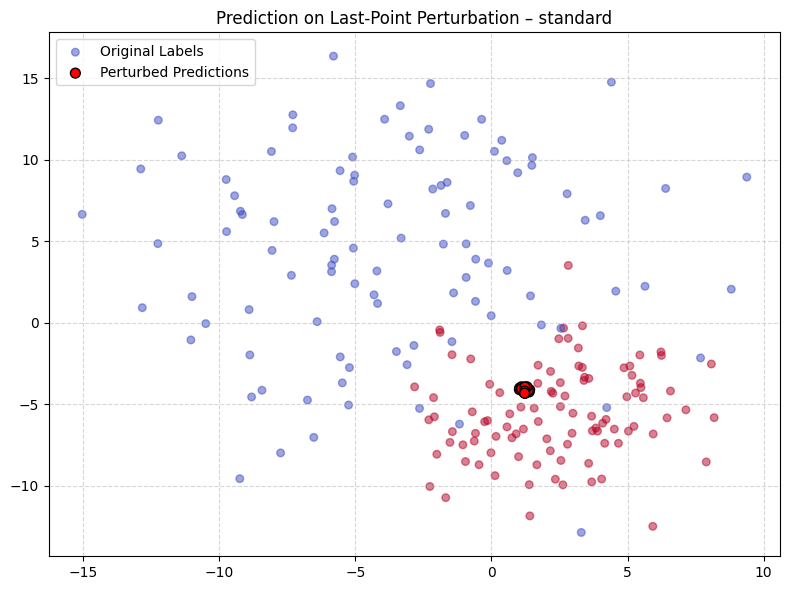

In [114]:
# 对一个具体 sample 复制若干次 + 加扰动
X0 = xs[0].clone()        # shape [200, 2]
ys0 = ys_[0].clone()      # shape [200, 2]

# 生成多个扰动版本
perturb_count = 32
X_perturbed = []
ys_perturbed = []

for _ in range(perturb_count):
    x_new = X0.clone().cpu()
    x_new[-1] += torch.randn(2) * 0.1  # 只扰动最后一个点
    X_perturbed.append(x_new)
    ys_perturbed.append(ys0)

X_batch = torch.stack(X_perturbed).to(device)  # shape [B, 200, 2]
ys_batch = torch.stack(ys_perturbed).to(device)
inds = [199] * perturb_count

with torch.no_grad():
    pred = model(X_batch, ys_batch, inds=[199])
    pred_labels = pred.argmax(dim=-1).cpu().numpy()

    # 获取原始 context 和扰动点
    context_points = X0.cpu().numpy()        # shape [200, 2]
    perturb_points = X_batch[:, -1].cpu().numpy()  # shape [B, 2]
    
    

    # 显示
    plt.figure(figsize=(8, 6))
        # 原始 context：按真实 label 上色
    true_labels = ys0.argmax(dim=-1).cpu().numpy()  # [200]
    plt.scatter(context_points[:, 0], context_points[:, 1],
                c=true_labels, cmap='coolwarm', s=30, alpha=0.5, label='Original Labels')

    # 扰动点：按预测 label 上色（红/蓝）
    colors = ['red' if l == 1 else 'blue' for l in pred_labels]
    plt.scatter(perturb_points[:, 0], perturb_points[:, 1], c=colors,
                edgecolor='k', s=50, label='Perturbed Predictions')

    plt.title(f"Prediction on Last-Point Perturbation – {prompting_strategy}")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()



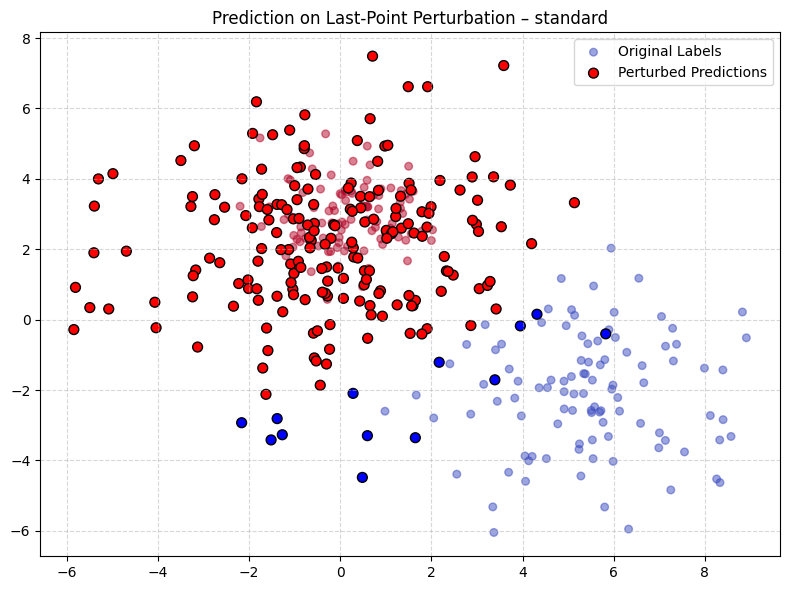

In [253]:
import random
# 对一个具体 sample 复制若干次 + 加扰动
X0 = xs[0].clone()        # shape [200, 2]
ys0 = ys_[0].clone()      # shape [200, 2]

# ✅ Step 1: 打乱顺序（同时打乱 X0 和 ys0）
perm = torch.randperm(X0.shape[0])
X0_shuffled = X0[perm]
ys0_shuffled = ys0[perm]

# ✅ Step 2: 生成扰动版本
perturb_count = 200
X_perturbed = []
ys_perturbed = []

for _ in range(perturb_count):
    x_new = X0_shuffled.clone().cpu()
    x_new[-1] += torch.randn(2) * 2 # 只扰动最后一个点
    X_perturbed.append(x_new)
    ys_perturbed.append(ys0_shuffled)

X_batch = torch.stack(X_perturbed).to(device)  # shape [B, 200, 2]
ys_batch = torch.stack(ys_perturbed).to(device)
inds = [199] * perturb_count

with torch.no_grad():
    pred = model(X_batch, ys_batch, inds=[199])
    pred_labels = pred.argmax(dim=-1).cpu().numpy()

    # 获取原始 context 和扰动点
    context_points = X0_shuffled.cpu().numpy()        # shape [200, 2]
    perturb_points = X_batch[:, -1].cpu().numpy()  # shape [B, 2]

    # 显示
    plt.figure(figsize=(8, 6))
        # 原始 context：按真实 label 上色
    true_labels = ys0_shuffled.argmax(dim=-1).cpu().numpy()  # [200]
    plt.scatter(context_points[:, 0], context_points[:, 1],
                c=true_labels, cmap='coolwarm', s=30, alpha=0.5, label='Original Labels')

    # 扰动点：按预测 label 上色（红/蓝）
    colors = ['red' if l == 1 else 'blue' for l in pred_labels]
    plt.scatter(perturb_points[:, 0], perturb_points[:, 1], c=colors,
                edgecolor='k', s=50, label='Perturbed Predictions')

    plt.title(f"Prediction on Last-Point Perturbation – {prompting_strategy}")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


In [43]:
X = xs
y = ys
resolution = 30
task = prompting_strategy

[-16.03297043 -13.87134933]
torch.Size([1, 200, 2])
torch.Size([1, 200, 2])
torch.Size([1, 2])


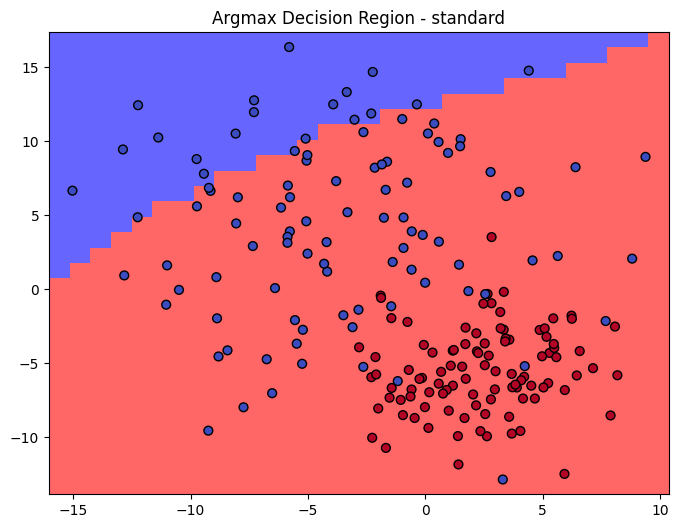

In [90]:

X_noised = X + torch.rand_like(X) * 0.1

X_np = X[0].cpu().numpy()
y_np = y[0].cpu().numpy()

device = next(model.parameters()).device

# 生成网格点
x_min, x_max = X_np[:, 0].min() - 1, X_np[:, 0].max() + 1
y_min, y_max = X_np[:, 1].min() - 1, X_np[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, resolution),
                        np.linspace(y_min, y_max, resolution))
grid = np.c_[xx.ravel(), yy.ravel()]  # (resolution^2, 2)
# grid += np.random.uniform(-0.1, 0.1, grid.shape)
# 预测每个 grid 点的概率
probs = []
class_map = []
flag = True
for i in range(len(grid)):
    g = grid[i]
    # 去掉最后一个点
    X_ctx = X_noised[0][:-1]  # shape: (199, 2)
    ys_ctx = ys_[0][:-1]  # shape: (199, 2)

    g_tensor = torch.tensor(g, dtype=torch.float32).unsqueeze(0).to(device)

    x_comb = torch.cat([X_ctx, g_tensor], dim=0).unsqueeze(0).to(device)

    ys_dummy = torch.full((1, 2), 0.5).to(device)  # dummy label 中性，不影响预测
    ys_comb = torch.cat([ys_ctx, ys_dummy], dim=0).unsqueeze(0).to(device)
    
    if flag:
        print(g)
        print(ys_comb.shape)
        print(x_comb.shape)
        print(g_tensor.shape)
        flag = False
        
    with torch.no_grad():
        pred = model(x_comb, ys_comb, inds=[x_comb.shape[1]-1])  # 只预测最后一个点
        # prob = torch.softmax(pred, dim=-1)[0, 0, 1].item()
        pred_label = pred.argmax(dim=-1).item()  # 0 或 1
        class_map.append(pred_label)
        # probs.append(prob)

# 转成 heatmap
class_map = np.array(class_map).reshape(xx.shape)

# prob_map = np.array(probs).reshape(xx.shape)
# print(prob_map)

# 二值化分类图：>0.5 为 class 1，<=0.5 为 class 0
# class_map = (prob_map > 0.5).astype(int)  # 0/1 map

# 可视化分类区域
plt.figure(figsize=(8, 6))
plt.imshow(class_map, extent=(x_min, x_max, y_min, y_max),
        origin='lower', cmap='bwr', alpha=0.6, aspect='auto',
        vmin=0, vmax=1)  
# plt.contour(xx, yy, class_map, levels=[0.5], colors='black') 
plt.scatter(X_np[:, 0], X_np[:, 1], c=y_np, cmap='coolwarm', edgecolor='black', s=40)
plt.title(f"Argmax Decision Region - {task}")
plt.savefig(f"/mnt/data/jinzi/numerical-in-context-learning-cluster/src/fig/argmax_region_{task}.png")
plt.show()

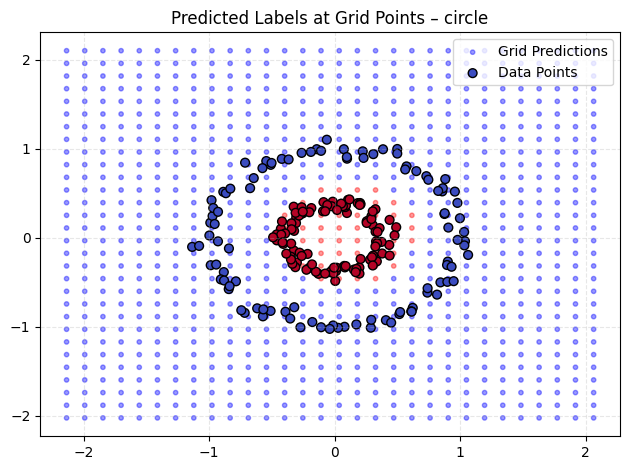

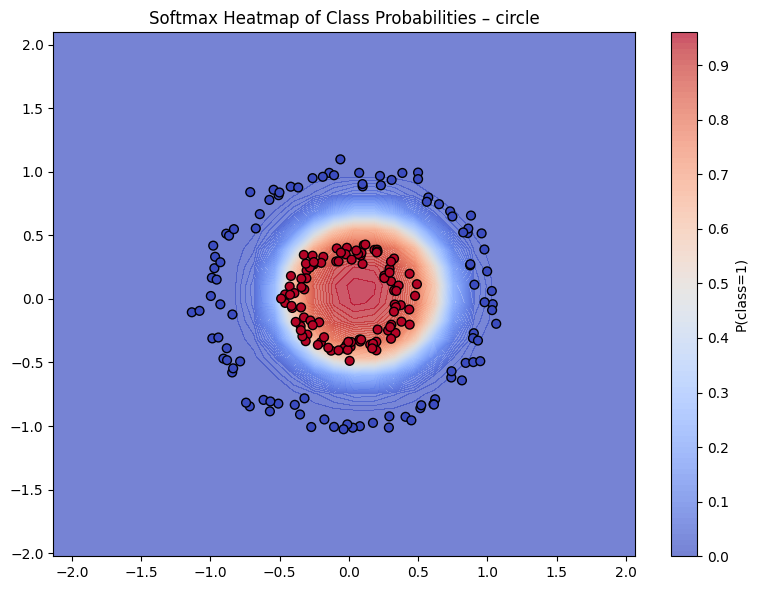

In [44]:
batch_size = 64
device = next(model.parameters()).device

# 1. 准备数据
X_noised = X.to(device)  # 确保整个 X 在 device 上
ys_ = ys_.to(device)     # one-hot label 同样放到 device

X_np = X[0].cpu().numpy()
y_np = y[0].cpu().numpy()

# 2. 构造网格点
x_min, x_max = X_np[:, 0].min() - 1, X_np[:, 0].max() + 1
y_min, y_max = X_np[:, 1].min() - 1, X_np[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, resolution),
                     np.linspace(y_min, y_max, resolution))
grid = np.c_[xx.ravel(), yy.ravel()]  # shape: [M, 2]
M = grid.shape[0]

# 3. 构造 context，并确保在 device 上
X_ctx = X_noised[0][:-1]          # [199, 2]
ys_ctx = ys_[0][:-1]              # [199, 2]

# 4. 补齐最后一个 batch
if M % batch_size != 0:
    pad = batch_size - (M % batch_size)
    grid = np.concatenate([grid, np.repeat(grid[-1:], pad, axis=0)], axis=0)

# 5. 批量预测
pred_labels = []
pred_probs = []

for i in range(0, len(grid), batch_size):
    grid_batch = torch.tensor(grid[i:i+batch_size], dtype=torch.float32, device=device)  # [B, 2]

    # 拼接 context + query (复制 B 次)
    X_ctx_batch = X_ctx.unsqueeze(0).repeat(batch_size, 1, 1)   # [B, 199, 2]
    g_batch = grid_batch.unsqueeze(1)                           # [B, 1, 2]
    x_comb = torch.cat([X_ctx_batch, g_batch], dim=1)           # [B, 200, 2]

    ys_ctx_batch = ys_ctx.unsqueeze(0).repeat(batch_size, 1, 1) # [B, 199, 2]
    ys_dummy = torch.full((batch_size, 1, 2), 0.5, device=device)  # [B, 1, 2]
    ys_comb = torch.cat([ys_ctx_batch, ys_dummy], dim=1)        # [B, 200, 2]

    inds = [199]  # ✅ 不是 * batch_size，模型会自动按 B 复制

    with torch.no_grad():
        preds = model(x_comb, ys_comb, inds=inds)  # [B, 1, 2]
        labels = preds.argmax(dim=-1).squeeze(-1).cpu().numpy()  # shape: [B]
        probs = F.softmax(preds.squeeze(1), dim=-1)[:, 1]               # 取 class=1 的概率 [B]
        pred_probs.append(probs.cpu().numpy())
        pred_labels.append(labels)

# 6. 拼接 + reshape
pred_labels = np.concatenate(pred_labels, axis=0)[:M]  # 去掉补齐
class_map = pred_labels.reshape(xx.shape)
prob_map = np.concatenate(pred_probs, axis=0)[:M].reshape(xx.shape)
# 预测的 grid 点分类上色（红 / 蓝）
grid_points = grid[:M]  # 去除 padding 后的原始 grid
colors = ['red' if l == 1 else 'blue' for l in pred_labels]

plt.scatter(grid_points[:, 0], grid_points[:, 1], c=colors,
            alpha=0.4, s=10, label='Grid Predictions')

# 原始数据点（真实标签）也一起画上去
plt.scatter(X_np[:, 0], X_np[:, 1], c=y_np, cmap='coolwarm',
            edgecolor='black', s=40, label='Data Points')

plt.title(f"Predicted Labels at Grid Points – {task}")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
# plt.savefig(f"/mnt/data/jinzi/numerical-in-context-learning-cluster/src/fig/argmax_gridpoints_{task}.png")
plt.show()

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, prob_map, levels=100, cmap='coolwarm', alpha=0.7)
plt.colorbar(label='P(class=1)')

# 加入原始点标注
plt.scatter(X_np[:, 0], X_np[:, 1], c=y_np, cmap='coolwarm', edgecolor='black', s=40)
plt.title(f"Softmax Heatmap of Class Probabilities – {task}")
plt.tight_layout()
plt.show()


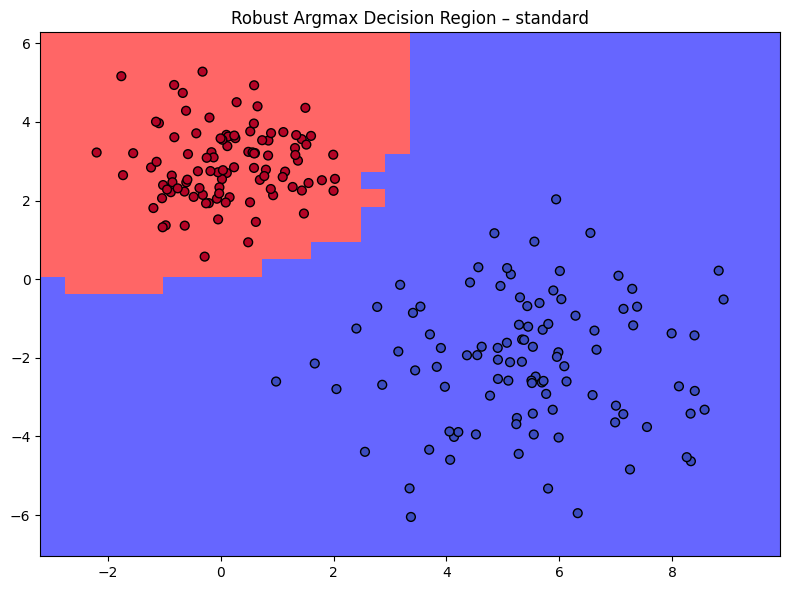

In [255]:
B = 32  # 每个点重复次数

# 对一个具体 sample 复制若干次 + 加扰动
X0 = xs[0].clone()        # shape [200, 2]
ys0 = ys_[0].clone()    

X0_  = X0.cpu().numpy()# shape [200, 2]

# 2. 构造网格点
x_min, x_max = X0_[:, 0].min() - 1, X0_[:, 0].max() + 1
y_min, y_max = X0_[:, 1].min() - 1, X0_[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, resolution),
                     np.linspace(y_min, y_max, resolution))
grid = np.c_[xx.ravel(), yy.ravel()]  # shape: [M, 2]
M = grid.shape[0]

M = len(grid)

x_ctx = X0[:-1].to(device)   # X0 本身已经是 shape [200, 2]  # 正确的 Tensor 上下文
y_ctx = ys_[0][:-1].to(device)

pred_labels = []
k=1
for i in range(M):
    g = torch.tensor(grid[i], dtype=torch.float32).to(device)  # shape: [2]
    perm = torch.randperm(x_ctx.shape[0])
    x_ctx_shuffled = x_ctx[perm]
    y_ctx_shuffled = y_ctx[perm]

    # B 次扰动后的 query 点
    g_perturbed = g.unsqueeze(0).repeat(B, 1)  # [B, 2]

    # 上下文复制 B 次
    x_ctx_batch = x_ctx_shuffled.unsqueeze(0).repeat(B, 1, 1)  # [B, 199, 2]
    x_batch = torch.cat([x_ctx_batch, g_perturbed.unsqueeze(1)], dim=1)  # [B, 200, 2]

    y_ctx_batch = y_ctx_shuffled.unsqueeze(0).repeat(B, 1, 1)  # [B, 199, 2]
    y_dummy = torch.full((B, 1, 2), 0.5, device=device)  # [B, 1, 2]
    y_batch = torch.cat([y_ctx_batch, y_dummy], dim=1)  # [B, 200, 2]

    inds = [199] * B

    with torch.no_grad():
        pred = model(x_batch, y_batch, inds=[199])
        pred_mode = pred.argmax(dim=-1).squeeze().mode()[0].item()
        pred_labels.append(pred_mode)

# 3. 转换为 class map
class_map = np.array(pred_labels).reshape(xx.shape)

# 4. 可视化
plt.figure(figsize=(8, 6))
plt.imshow(class_map, extent=(x_min, x_max, y_min, y_max),
           origin='lower', cmap='bwr', alpha=0.6, aspect='auto',
           vmin=0, vmax=1)
plt.scatter(X0[:, 0].cpu(), X0[:, 1].cpu(),
            c=ys0.argmax(dim=-1).cpu(), cmap='coolwarm',
            edgecolor='black', s=40)
plt.title(f"Robust Argmax Decision Region – {prompting_strategy}")
plt.tight_layout()
plt.show()

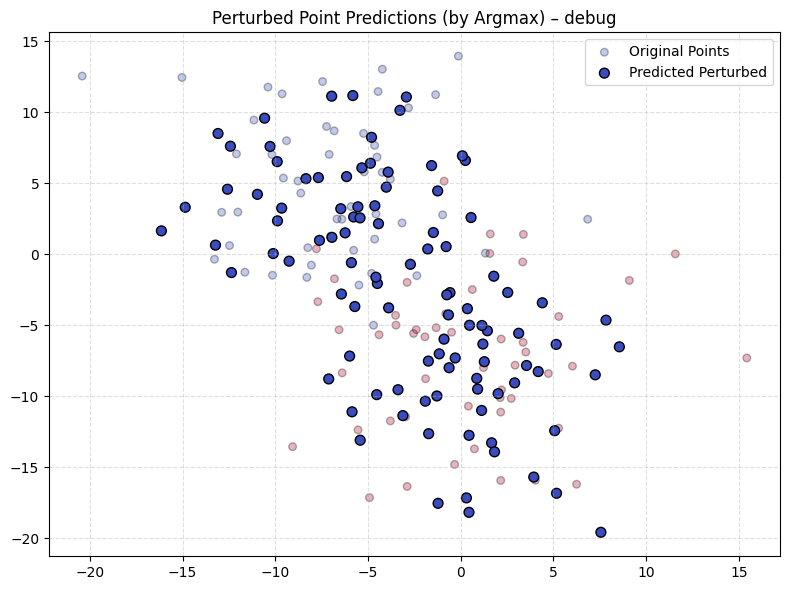

In [93]:
task="debug"
n_new_points=100
noise_level=0.01
falg = True
X_np = X[0].cpu().numpy()
y_np = y[0].cpu().numpy()
ys_onehot = ys_[0]  # shape: (N, 2)

# 1. 随机从原始点中选 n 个点，做 local 扰动生成测试点
idx = np.random.choice(len(X_np), size=n_new_points, replace=False)
base_points = X_np[idx]  # (n_new_points, 2)
base_labels = ys_onehot[idx]  # 对应 one-hot label (n_new_points, 2)

# 加扰动
test_points = base_points + np.random.normal(scale=noise_level, size=base_points.shape)

pred_labels = []

for i in range(n_new_points):
    # context: 去掉一个点
    X_ctx = X[0][:-1]
    ys_ctx = ys_onehot[:-1]
    

    # 拼接扰动点
    g_tensor = torch.tensor(test_points[i], dtype=torch.float32).unsqueeze(0).to(device)
    x_comb = torch.cat([X_ctx, g_tensor], dim=0).unsqueeze(0).to(device)

    y_dummy = base_labels[i].unsqueeze(0).to(device)  # <== 修正点！！
    if flag == True:
        print(ys_ctx.shape)
        print(y_dummy)
        flag = False
    ys_comb = torch.cat([ys_ctx, y_dummy], dim=0).unsqueeze(0).to(device)

    with torch.no_grad():
        pred = model(x_comb, ys_comb, inds=[x_comb.shape[1]-1])
        pred_label = pred.argmax(dim=-1).item()
        pred_labels.append(pred_label)

pred_labels = np.array(pred_labels)  # (n_new_points,)

# 2. 画图：测试点的预测分类结果
plt.figure(figsize=(8, 6))

# 原始点（淡色轮廓，作为背景）
plt.scatter(X_np[:, 0], X_np[:, 1], c=y_np, cmap='coolwarm',
            edgecolor='k', s=30, alpha=0.3, label='Original Points')

# 扰动点，颜色 = 模型预测结果（红蓝），marker=•
plt.scatter(test_points[:, 0], test_points[:, 1], c=pred_labels,
            cmap='coolwarm', marker='o', edgecolor='black', s=50, label='Predicted Perturbed')

plt.title(f"Perturbed Point Predictions (by Argmax) – {task}")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

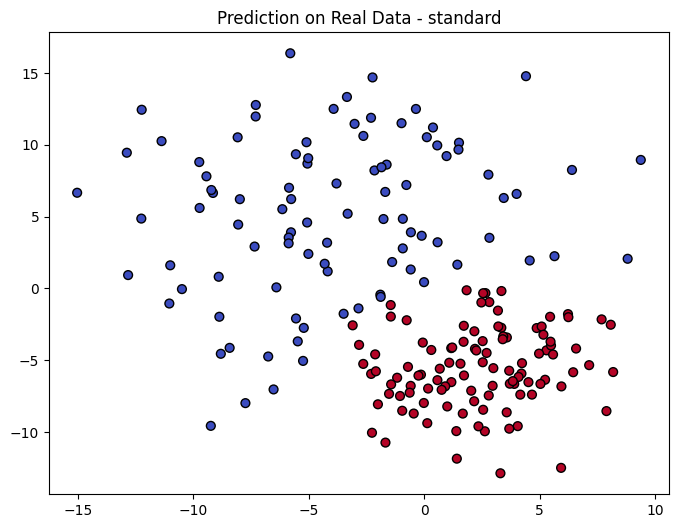

In [233]:
with torch.no_grad():
    pred_real = model(torch.tensor(X_np, dtype=torch.float32).unsqueeze(0).to(device), ys_[0].unsqueeze(0).to(device))
    pred_labels_real = pred_real.argmax(dim=-1)[0].cpu().numpy()  # shape: (N,)

plt.figure(figsize=(8, 6))
plt.scatter(X_np[:, 0], X_np[:, 1], c=pred_labels_real, cmap='coolwarm', edgecolor='black', s=40, label='Predicted')
plt.title(f"Prediction on Real Data - {task}")
plt.savefig(f"/mnt/data/jinzi/numerical-in-context-learning-cluster/src/fig/real_data_prediction_{task}.png")
plt.show()